#### Purpose of this kernel

- try out variation of architecture presented in this paper: https://arxiv.org/pdf/1801.04433              
 → "Detecting offensive language in tweets using deep learning"
- using only one Bidirectional CuDNNLSTM Layer
- add Dense(32) with relu activation function

#### Import libraries

In [1]:
%%capture --no-stdout

# General
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook 
tqdm_notebook().pandas()
import os
import gc
import sys
import time

# Preprocessing
import seaborn as sns
import re
from re import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
lemmatizer = nltk.WordNetLemmatizer()

# Modeling
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import SimpleRNN, GRU, Bidirectional, LSTM,CuDNNLSTM, CuDNNGRU
from keras.layers import SpatialDropout1D

# Training
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

    
# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
# Check status and availability of GPU
import tensorflow as tf
print("GPU on?  - ", tf.test.is_gpu_available())
print("Available GPUs: ", tf.test.gpu_device_name())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

GPU on?  -  True
Available GPUs:  /device:GPU:0


#### Hyperparameters

In [3]:
# Fast Run Testing
# total_train_samples = 100000 # max is 1306122
total_train_samples = 1306122 # max is 1306122

# Preprocessing
maxlen = 130 # 130 - covers about 75% of all bad questions completely
max_words = 9999999 # if all words shall be used, type huge number here

# Modeling
embedding_dim = 300 # set to 300 to be able to compare with pre-trained embeddings

# Training
kfolds = 3 # 80/20 split
model_epochs = 10

## Load Data

In [4]:
df = pd.read_csv("../input/train.csv")
str_ = 'Train data loaded'
os.system('echo '+str_)

0

In [5]:
df = df[:total_train_samples] # for Testing purposes
num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

X = df.loc[:, 'question_text'].values
y = df.loc[:, 'target'].values

# Since Neural Networks are only able to perform transformations on tensors 
y = np.asarray(y) # Transformation target labels to numpy array 

print('Shape data tensor:', X.shape) 
print('Shape target tensor:', y.shape) # 1D Tensor

pd.set_option('display.max_colwidth', 1500) # inrease display column size
df.head(3)

Shape for this run:  1306122 3
Shape data tensor: (1306122,)
Shape target tensor: (1306122,)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0


## Preprocessing

### Data Preparation (1)  - tokenization

In [6]:
def my_tokenizer(texts):
        tokenizer = Tokenizer() 
        tokenizer.fit_on_texts(texts) 
        sequences = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(sequences, maxlen=maxlen)  
        word_index = tokenizer.word_index  
        
        return padded_seq, word_index

### Data Preparation (2)  - Embeddings

In [7]:
# Embeddings path
_glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
_paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
_wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
_google_news = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

embeddings = [
                #{'name': 'glove', 'embeddings_path': _glove},
              {'name': 'paragram', 'embeddings_path': _paragram}#,
              #{'name': 'fasttext', 'embeddings_path': _wiki_news},
              #{'name': 'googlenews', 'embeddings_path': _google_news}
                ]

#### Definition of functions to load and analyse embeddings

In [8]:
# Functions for lemmatization from http://textmining.wp.hs-hannover.de/Preprocessing.html

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)

In [9]:
# Function to create embedding matrix
embedding_matrices = {}
words_in_embedding = {}
def create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_dict):

    embedding_dim = 300 # (vector size 300!)
    embedding_matrix = np.zeros((max_words+1, embedding_dim))
    unknown_words_list = []
    num_known_words = 0  
        
    ps = PorterStemmer()
    ps_counter = 0
    lc = LancasterStemmer()
    lc_counter = 0
    sb = SnowballStemmer("english")
    sb_counter = 0
    lemma_counter = 0

    # Filling up matrix
    for word, i in word_index.items(): 
        
        if embeddings_name in ['glove', 'paragram', 'fasttext'] and i <= max_words:
            
            embedding_vector = embeddings_dict.get(word) # get vector for word from embedding 
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.lower()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.capitalize()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.upper()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = ps.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                ps_counter +=1
                continue # if embedding found - process next word
                
            word_c = lc.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lc_counter +=1
                continue # if embedding found - process next word
                
            word_c = sb.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                sb_counter +=1
                continue # if embedding found - process next word
                
            word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1]))
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lemma_counter +=1
                continue # if embedding found - process next word
                
            else:
                unknown_words_list.append(word)
                
        if embeddings_name == 'googlenews' and i <= max_words:
            
            try:
                word_c = word
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word

                word_c = word.lower()
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                
                word_c = word.capitalize()
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1 
                    continue # if embedding found - process next word
                
                word_c = word.upper()
                embedding_vector = embeddings_dict[word_c]   
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                    
                word_c = ps.stem(word)
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    ps_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = lc.stem(word)
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lc_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = sb.stem(word)
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    sb_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1]))
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lemma_counter +=1
                    continue # if embedding found - process next word
                    
            except:
                unknown_words_list.append(word)
                
    try: 
        words_in_embedding[embeddings_name] = list(embeddings_dict.keys())
    except:
        try:
            words_in_embedding[embeddings_name] = list(embeddings_dict.wv.vocab)
        except:
            print("Error during generation of key list {}".format(embeddings_name))
            print(sys.exc_info()[0])
    
    # Save embedding matrix:
    embedding_matrices[embeddings_name] = embedding_matrix
    
    
    print('  Embeddings_matrix created')
    print('  Shape embedding_matrix: {}'.format(embedding_matrix.shape))
    print('  Found Embeddings for {:.2f}% of all words'
          .format((num_known_words / max_words)*100))
    print("  num_known_words :", num_known_words)
    print("  num words in word_index: ", max_words)
    print('  Unknown Words: {:.2f}%'.
          format(((len(unknown_words_list)) / max_words)*100))
    print("  Words found by PorterStemmer: {}".format(ps_counter))
    print("  Words found by LancasterStemmer: {}".format(lc_counter))
    print("  Words found by SnowballStemmer: {}".format(sb_counter))
    print("  Words found by Lemmatisation: {}".format(lemma_counter))
          
    # Top 50 unknown words
    print("  Top 50 unknown words:\n {}\n".format(unknown_words_list[:50]))
    
    del num_known_words, unknown_words_list,ps,lc,sb, ps_counter, lc_counter, sb_counter
    del embedding_matrix, lemma_counter; gc.collect() 

In [10]:
# Function to load + analyze Embeddings
def load_and_analyse_Embeddings(embeddings_name, embeddings_path, max_words):
    
    if embeddings_name in ['glove', 'paragram', 'fasttext']:  
        embeddings_dict = {} # create empty embedding dictionary
        embedding_file = open(embeddings_path, encoding ="utf8", errors = 'ignore') # load embedding from path

        # Fill embedding dict with word: vector(coefs) pairs
        for line in embedding_file:
            line_values = line.split(' ') # read in values of respective line (= vector)
            word = line_values[0] #  # first value in line represents the word
            coefs = np.asarray(line_values[1:], dtype='float32') # all values represent vector
            embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

        embedding_file.close() 
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        print('  {} word vectors within {} dict'.format(len(embeddings_dict),embeddings_name))
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_dict)
        del embeddings_dict, line_values,word,coefs
                
    if embeddings_name == 'googlenews':
        embeddings_file = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_file)
        del embeddings_file
        
    # MEMORY MANAGEMENT!
    del embeddings_name, embeddings_path
    gc.collect()
    
   # return embeddings_dict

### Data Preparation (3)  - Data Cleaning

#### Definition mapping and functions

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am","i'm": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not","what`s": "what is", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have"}

# dict from https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 
correct_spell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                    'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                    'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                    'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                    'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                    'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                    'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                    'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                    'howdoes': 'how does', 'mastrubation': 'masturbation',
                    'mastrubate': 'masturbate', "mastrubating": 'masturbating',
                    "mcdonald's":'mcdonalds',
                    'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
                    'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 
                    'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                    'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                    'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                    'pokémon': 'pokemon', 'quoras': 'quora', 'quorans': 'quora'}

# Kernel "fork-embeddings-keras-v04"
specials_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", 
                 "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', 
                 '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 
                 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ',
                 '…': ' ... ', '\ufeff': '', 'करना': '', 'है': '', 'ε−': ''}

punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&' + '\''

In [12]:
def preprocessing(x):
    x = str(x)
    x = re.sub('[’‘´`]', "'", x) 
    
    # replaces one digit by #, two following digits by ## etc.
    x = re.sub('[0-9]{5,}', '#####', str(x)) 
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]\'[0-9]', 'feet inches', x) # e.g. 5'5 → feet inches
    
    for word in x.split():
        if word.lower() in contraction_mapping.keys():
            x = x.replace(word, contraction_mapping[word.lower()])
        if word in correct_spell_dict.keys():
            x = x.replace(word, correct_spell_dict[word])
        if word in specials_mapping.keys():
            x = x.replace(word, specials_mapping[word])
        if word[0] in punct and len(word) != 1: # remove punctuation directly in front of word
            x = x.replace(word[0], '') 
        
    x = ' '.join(word_tokenize(x)) # separates puncutation from words
               
    return x

#### Apply preprocessing functions

In [13]:
os.system('echo Applying preprocessing functions..')
df["question_text"] = df["question_text"].fillna("_nan_").progress_apply(lambda x: preprocessing(x))
os.system('echo prepocessing done')

X = df.loc[:, 'question_text'].values
y = np.asarray(df.loc[:, 'target'].values)

padded_seq, word_index = my_tokenizer(X) # translate text to numerical values
max_words = min(max_words, len(word_index)) # e.g.10k words or all words
      # index +1 because fill process of matrix starts at 1
print(" Number of words in word_index: ", len(word_index))
os.system('echo Tokenization completed')


 Number of words in word_index:  189036


0

#### Iteration loop to compare different embeddings (3)

In [14]:
for embedding in embeddings:
    emb_name = embedding['name']
    emb_path = embedding['embeddings_path']
    print("Running procedure on {}:".format(emb_name))
    
    load_and_analyse_Embeddings(emb_name, emb_path, max_words) # loading embedding

os.system("echo load_and_analyse_Embeddings done")

Running procedure on paragram:
   paragram loaded
  1703755 word vectors within paragram dict
  Embeddings_matrix created
  Shape embedding_matrix: (189037, 300)
  Found Embeddings for 78.83% of all words
  num_known_words : 149009
  num words in word_index:  189036
  Unknown Words: 21.17%
  Words found by PorterStemmer: 4308
  Words found by LancasterStemmer: 5359
  Words found by SnowballStemmer: 90
  Words found by Lemmatisation: 79
  Top 50 unknown words:
 ['brexit', 'cryptocurrencies', 'redmi', 'coinbase', 'oneplus', 'upwork', 'machedo', 'gdpr', 'adityanath', 'boruto', 'bnbr', 'alshamsi', 'dceu', 'litecoin', 'unacademy', 'iiest', "qur'an", 'zerodha', 'tensorflow', 'doklam', 'kavalireddi', 'lnmiit', 'muoet', 'etc…', 'nicmar', 'vajiram', '°c', 'zebpay', 'srmjee', 'elitmus', 'altcoins', 'altcoin', 'hackerrank', 'awdhesh', 'baahubali', 'koinex', 'demonetisation', 'mhcet', 'byju', 'srmjeee', 'sgsits', 'ftre', 'skripal', 'nanodegree', 'gurugram', 'hotstar', 'mhtcet', 'x²', 'bmsce', 'wha

0

## Modeling

* starting with a simple neural network
* model is encapsulated into a function for clarity reasons and to make model easier for later submission 
* literature recommends not to use pre-trained embeddings in case of the availability of a large dataset. 1.3 million questions are available in the train-set, which should be worth a try. The Embedding Layer tries to derive optimal vectors for the input words. After training the weights of the Embedding Layer represent these vectors.
* state-of-the-art loss function for binary classification tasks: **binary_crossentropy**
* **optimizer rmsprop** is in most-cases a good choice according to current research literature
* using the default learning rate of rmsprop is recommended and applied here

In [15]:
def get_keras_model():
    model = Sequential()
    model.add(Embedding(input_dim = max_words+1, # 10k different words/integers
                        output_dim = embedding_dim, 
                        weights = [embedding_matrices['paragram']],
                        trainable = False)) 
    
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(CuDNNLSTM(64)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # final -  binary classifier
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

get_keras_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         56711100  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               187392    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 56,900,573
Trainable params: 189,473
Non-trainable params: 56,711,100
_________________________________________________________________


### Training + Evaluation

* Input for model are batches of sequences
        * Input shape: 2D tensor(matrix): (batch_size, sequence_length).
* each sequence has a maximum length of maxlen (here: 100)
* Embedding Layer translates Integers of each sequence into dense vectors
  (comp. https://keras.io/layers/embeddings/)
      * input_length: Length of input sequence
* embedding_matrix translates integers into into 3D Tensores of shape:
      * Output shape: (batch_size, sequence_length, output_dim)


* accuracy metric is not suitable is cases target classes are quite unequal distributed
* ROC-AUC is also not applicable for the same reason
* Suitable Evaluation metrics: Precision, Recall and F1-Score as combination of both. Since these metric functions were removed in Keras 2.0, they are implemented within an own callback below. # class based on:
https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [16]:
class CustomMetric(Callback):

    # Create Instance at the beginning of each epoch
    def on_train_begin(self, logs={}):
        self.best_val_f1s = [] # collects best f1 after each epoch with best threshold
    
    # Function called at the end of ery epoch
    def on_epoch_end(self, epoch, logs={}):
        t0 = time.time()
        
        val_predict = np.asarray(self.model.predict(self.validation_data[0])) 
        val_target = self.validation_data[1]
        
        # Find best threshold for prediction
        best_f1 = 0               
        for threshold in np.arange(0.2,0.401, 0.01):
            val_f1 = f1_score(y_true = val_target, y_pred = val_predict > threshold)
            if val_f1 > best_f1:
                best_f1 = val_f1

        self.best_val_f1s.append(best_f1)
        
        t1 = time.time()
        if epoch % 2 == 0:
            print("  -- epoch: {}".format(epoch))  
            print("Execution time on_epoch_end {}".format(t1-t0))
            os.system("echo  -- epoch: {}".format(epoch))
            os.system("echo Execution time on_epoch_end {}".format(t1-t0))
        return

* StratifiedKFold: training is performed "kfold"- time, within each fold several epochs are run.

In [17]:
my_y_val_preds = {} # dictionary to collect model predictions at the end of each split
my_y_val_targets = {} # dictionary of true classes at the end of each split
my_history_dict = {} # to collect accuracy of each epoch
my_metrics_dict = {} # to collect best f1 of each epoch
best_f1_dict = {} # final evaluation at the end of training (after last epoch)
best_threshold_dict = {} # final evaluation at the end of training (after last epoch)

# fold_list contains train and validation indices (folds) for each split
# fold_list contains train and validation indices (folds) for each split
folds = StratifiedShuffleSplit(n_splits=kfolds, test_size=0.2, random_state=123).split(padded_seq, y)

tf.logging.set_verbosity(tf.logging.ERROR) # dont show warnings (e.g. tensorflow version problems)
for i, (train_indices, val_indices) in enumerate(folds):
    start_fold = time.time()
    
    print('\nSplit: {}  \n '.format(i))
    os.system("echo running split {}".format(i))
    X_train, X_val = padded_seq[train_indices], padded_seq[val_indices] 
    y_train, y_val = y[train_indices], y[val_indices] 

    model = get_keras_model() # create new model for current split
    my_metrics = CustomMetric() # create new metrics instance
 
    # Training process is logged in history object for visualisation purposes
    # within each split setting the model is trained several epochs (complete fit)
    history = model.fit(X_train, y_train,
                        epochs = model_epochs, 
                        batch_size= 512,
                        verbose = 0, 
                        validation_data=(X_val, y_val),
                        callbacks = [my_metrics])
    
    ############## at the end of each training process: ##################
    
    my_history_dict[i] = history
    my_metrics_dict[i] = my_metrics
        
    y_val_pred = model.predict(X_val) # prediction on 
    my_y_val_preds[i] = y_val_pred 
    my_y_val_targets[i] = y_val
    
    # Find best threshold for prediction
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0.1,0.5, 0.01):
        # calucate f1 score for allowed thresholds
        f1_score_threshold = f1_score(y_true = y_val ,
                                              y_pred = y_val_pred > threshold) # 0 or 1
        if f1_score_threshold > best_f1:
            best_f1 = f1_score_threshold
            best_threshold = threshold
            best_f1_dict[i] = best_f1
            best_threshold_dict[i] = best_threshold
            
    stop_fold = time.time()
    print("Execution time Fold {}: {}.".format(i, (stop_fold - start_fold)))
    os.system("echo Execution time Fold {}: {}.".format(i, (stop_fold - start_fold)))


Split: 0  
 
  -- epoch: 0
Execution time on_epoch_end 40.29148006439209
  -- epoch: 2
Execution time on_epoch_end 40.67951703071594
  -- epoch: 4
Execution time on_epoch_end 40.29788017272949
  -- epoch: 6
Execution time on_epoch_end 39.145400285720825
  -- epoch: 8
Execution time on_epoch_end 39.180415391922
Execution time Fold 0: 1157.2851316928864.

Split: 1  
 
  -- epoch: 0
Execution time on_epoch_end 39.13951110839844
  -- epoch: 2
Execution time on_epoch_end 39.349684953689575
  -- epoch: 4
Execution time on_epoch_end 39.36647891998291
  -- epoch: 6
Execution time on_epoch_end 39.42509889602661
  -- epoch: 8
Execution time on_epoch_end 39.491289377212524
Execution time Fold 1: 1148.2628915309906.

Split: 2  
 
  -- epoch: 0
Execution time on_epoch_end 39.14884686470032
  -- epoch: 2
Execution time on_epoch_end 39.013399839401245
  -- epoch: 4
Execution time on_epoch_end 39.70863103866577
  -- epoch: 6
Execution time on_epoch_end 39.02943301200867
  -- epoch: 8
Execution time o

In [18]:
thresh_avg = 0
thresh_sum = 0
f1_avg = 0
f1_sum = 0

for key, value in best_f1_dict.items():
    print("Split: {} : Best F1 score: {:6.4f} reached with a threshold of {:6.4f}"
          .format(key, best_f1_dict[key], best_threshold_dict[key]))
    thresh_sum += best_threshold_dict[key] 
    thresh_avg = thresh_sum/kfolds
    f1_sum += best_f1_dict[key] 
    f1_avg = f1_sum/kfolds
   
print("")
print("Threshold for prediction: {:6.4f}".format(thresh_avg))
print("Average F1-Score: {:5.3f}".format(f1_avg))

Split: 0 : Best F1 score: 0.6695 reached with a threshold of 0.3300
Split: 1 : Best F1 score: 0.6728 reached with a threshold of 0.3900
Split: 2 : Best F1 score: 0.6734 reached with a threshold of 0.4000

Threshold for prediction: 0.3733
Average F1-Score: 0.672


## Evaluation

* For the evaluation of unbalanced datasets the accuracy as e.g. implemented in SKLEARN's function cross_val_score() is NOT recommended
* A high F1 score is the target in this competition and combines precision and recall
* **Plotting information captured during training by History Object and Callback Object**

Split: 0 


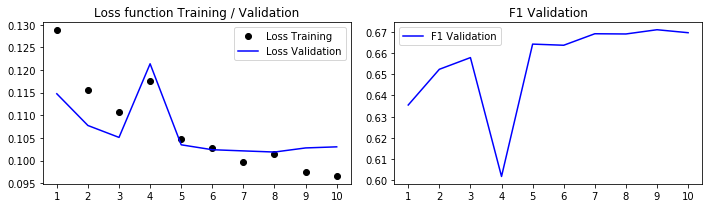

Split: 1 


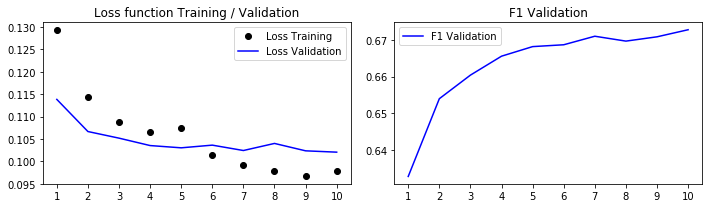

Split: 2 


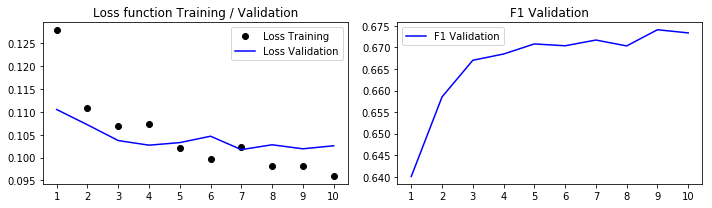

In [19]:
for i in my_history_dict:
    
    print('Split: {} '.format(i))
    loss = my_history_dict[i].history['loss']
    val_loss = my_history_dict[i].history['val_loss']
    epochs = np.arange(1, len(loss) +1, 1) # x-axis

    # Plotting:
    f = plt.figure(figsize=(10,3))
    # plots loss
    f.add_subplot(1, 2, 1) # number of rows, number of columns,subplot you're currently on.
    plt.xticks(epochs)
    plt.plot(epochs, loss, 'bo', label='Loss Training', color = 'black')
    plt.plot(epochs, val_loss, 'b', label='Loss Validation')
    plt.title('Loss function Training / Validation')
    plt.legend()
 
    # plots f1 score
    f.add_subplot(1, 2, 2)
    best_val_f1s = my_metrics_dict[i].best_val_f1s
   # plt.figure()
    plt.xticks(epochs)
    plt.plot(epochs, best_val_f1s, 'b', label='F1 Validation')
    plt.title('F1 Validation')
    plt.legend()
    
    #plt.subplots_adjust(wspace=0.30) # width reserved for blank space between subplots
    f.tight_layout()
    plt.show()